In [1]:
import keras
import os
import cv2
import numpy as np  
import pandas as pd 
import seaborn as sns     
import tensorflow as tf 
from termcolor import colored  
import matplotlib.pyplot as plt  
from IPython.display import display
from keras.models import Sequential
from keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape
sns.set_style('whitegrid')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
dir1 = r"C:\Users\jash1\Downloads\archive (8)\Rice_Image_Dataset"
# Detect classes
detection = [class_name for class_name in os.listdir(dir1) if class_name]
detection.remove('Rice_Citation_Request.txt')
print(detection)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [3]:
image_data = []  # Initialize an empty list for storing image paths and labels

# Iterate through each class in the detection
for class_name in detection:
    class_path = os.path.join(dir1, class_name)  # Create the path for the class
    files = os.listdir(class_path)  # List all files in the class folder
    
    # Loop through all files and add their paths and class labels to the image_data list
    for file in files:
        file_path = os.path.join(class_path, file)  # Create the full file path
        image_data.append((file_path, class_name))  # Append tuple to the list

# Convert the list to a pandas DataFrame
df = pd.DataFrame(image_data, columns=['path', 'label'])

# Shuffle the DataFrame rows for randomness
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df

,path,label
0,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Basmati
1,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Basmati
2,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Ipsala
3,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Basmati
4,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Jasmine
...,...,...
74995,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Ipsala
74996,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Basmati
74997,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Arborio
74998,C:\Users\jash1\Downloads\archive (8)\Rice_Imag...,Basmati


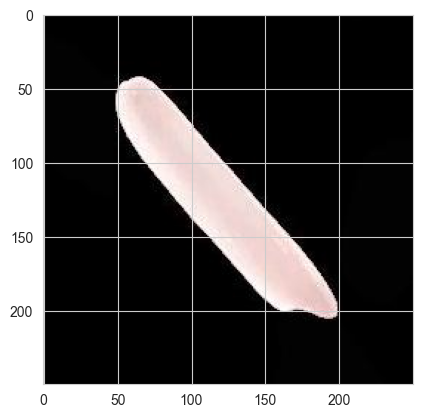

In [5]:
img = cv2.imread(df.iloc[0]['path'])
plt.imshow(img)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

training_data = df[:60000]
validation_data = df[60000:67500]
test_data = df[67500:]

IMAGE_SIZE = (250, 250)
BATCH_SIZE = 32
EPOCHS = 10

data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def create_data_generator(dataframe, is_training=False):
    return data_gen.flow_from_dataframe(
        dataframe,
        x_col='path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=is_training
    )

train_generator = create_data_generator(training_data, is_training=True)
valid_generator = create_data_generator(validation_data, is_training=False)
test_generator = create_data_generator(test_data, is_training=False)

images, labels = next(train_generator)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='selu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='selu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='selu'))
model.add(Dropout(0.5))

n_classes = len(train_generator.class_indices)
model.add(Dense(n_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 124, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)        0

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

235/235 [==============================] - 89s 377ms/step - loss: 0.1645 - accuracy: 0.9429
Test Accuracy: 94.29%
